In [1]:
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio import SeqIO
import csv
import math
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
def fasta_to_array(fasta_file):
    for record in SeqIO.parse(fasta_file, "fasta"):
        return list(str(record.seq))
    return []

def probability_file_to_array(file_path):
    with open(file_path, 'r') as file:
        return [float(token) for token in file.read().split()]

def get_positional_probabilities(database_array, probability_array): 
    index_dict = {}
    nucleotides = ['A', 'T', 'G', 'C']

    for i in range(len(database_array)):
        nucleotide_probabilities = {}
        other_probability = round((1 - probability_array[i]) / 3, 3)
        for nucleotide in nucleotides:
            if nucleotide == database_array[i]:
                nucleotide_probabilities[database_array[i]] = probability_array[i]
            else:
                nucleotide_probabilities[nucleotide] = other_probability
        index_dict[i] = nucleotide_probabilities
    return index_dict

def probabilistic_blast(database_array, probability_array, query_path='query_sequence.fasta', blast_db_path='database/my_database', heuristic=False, heuristic_num=10, heuristic_prob=0.1, word_size=4):
    positional_probabilities = get_positional_probabilities(database_array, probability_array)
    sequence_array = fasta_to_array(query_path)
    query_length = len(sequence_array)
    database_length = len(database_array)

    # Run BLAST
    blastn_cline = NcbiblastnCommandline(
        query=query_path,
        db=blast_db_path,
        evalue=1000,
        word_size=word_size,
        perc_identity=0,
        outfmt=6,
        out="-",
        ungapped=True,
        strand="plus"
    )
    stdout, stderr = blastn_cline()
    blast_results = stdout.splitlines()

    match_probability = {}
    max_prob = float('-inf')
    max_match = (0, 0)
    epsilon = 1e-10
    unlikely_match = False

    for row in csv.reader(blast_results, delimiter='\t'):
        probability = math.log(1)

        # Start and end indices of the BLAST match in the query sequence
        query_start = int(row[6]) - 1
        query_end = int(row[7]) - 1

        # Start and end indices of the BLAST match in the database sequence
        database_start = int(row[8]) - 1
        database_end = int(row[9]) - 1
        diff = database_start - query_start

        # The number of nucleotides to extend on the left of the seed, to match the length of the query sequence
        left_extension = query_start if query_start <= database_start else database_start
        # The number of nucleotides to extend on the right of the seed
        right_extension = query_length - query_end if query_length - query_end <= database_length - database_end else database_length - database_end

        # The start and end indices of the database after extending, to match the length of the query sequence
        extended_database_start = database_start - left_extension 
        extended_database_end = database_end + right_extension - 1

        # The start and end indices of the query after extending, to match the length of the query sequence
        extended_query_start = query_start - left_extension
        extended_query_end = query_end + right_extension - 1

        start_end_tuple = (extended_database_start, extended_database_end)

        consecutive_low_prob_count = 0
        for index in range(extended_database_start, extended_database_end):
            nucleotide = sequence_array[extended_query_start]
            nucleotide_prob = positional_probabilities[index][nucleotide]

            if heuristic: 
                if nucleotide_prob < heuristic_prob:
                    consecutive_low_prob_count += 1
                else:
                    consecutive_low_prob_count = 0
                if consecutive_low_prob_count >= heuristic_num:
                    unlikely_match = True
                    consecutive_low_prob_count = 0
                    continue

            probability += math.log(nucleotide_prob) if nucleotide_prob > 0 else math.log(epsilon)
            extended_query_start += 1

        if unlikely_match:
            unlikely_match = False
            continue

        if probability > max_prob:
            max_prob = probability
            max_match = start_end_tuple
        
        match_probability[start_end_tuple] = probability

    sorted_match_probabilities = dict(sorted(match_probability.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_match_probabilities

def generate_random_sequence(probabilities, min_length=10, max_length=1000, max_position=604465):
    # Randomly choose a starting position between 0 and max_position
    start_position = random.randint(0, max_position)

    # Randomly choose a length between 10 and the maximum possible length
    length = random.randint(min_length, max_length)

    sequence = []
    end_position = start_position + length - 1

    for position in range(start_position, end_position + 1):
        if position not in probabilities:
            raise ValueError(f"Position {position} is out of range of the probability dictionary.")
        
        nucleotide_probs = probabilities[position]
        nucleotides = list(nucleotide_probs.keys())
        probs = list(nucleotide_probs.values())

        # Randomly choose a nucleotide based on the probabilities
        chosen_nucleotide = random.choices(nucleotides, weights=probs, k=1)[0]
        sequence.append(chosen_nucleotide)

    sequence_string = ''.join(sequence)
    with open("query_sequence.fasta", "w") as fasta_file:
        fasta_file.write(">random_query_sequence\n")
        fasta_file.write(sequence_string + "\n")

    return sequence_string, start_position, end_position, length

In [3]:
# File paths
database_path = 'database.fasta'
sequence_path = 'query_sequence.fasta'
probability_path = 'database_probs.txt'

# Load database and probabilities
database_array = fasta_to_array(database_path)
probability_array = probability_file_to_array(probability_path)
positional_probabilities = get_positional_probabilities(database_array, probability_array)

# Evaluation parameters
word_sizes = [4, 6, 8, 10]
sequence_lengths = [10, 100, 1000]
heuristics = [False, True]
num_test_sequences = 100
# accuracies = [[] for _ in range(2)]
# average_run_times = [[] for _ in range(2)]
accuracies = {
    'word_size': [],
    'sequence_length': [],
    'heuristic': []
}
average_run_times = {
    'word_size': [],
    'sequence_length': [],
    'heuristic': []
}

# Run tests (words size)
for word_size in tqdm(word_sizes, desc="Testing word sizes"):
    correct_count = 0
    start_time = time.time()
    for _ in tqdm(range(num_test_sequences), desc=f"Testing word size {word_size}"):
        # Generate a random sequence of the specified length
        sequence, seq_start, seq_end, seq_length = generate_random_sequence(positional_probabilities, min_length=300, max_length=300)
        sequence_array = list(sequence)

        # Run probabilistic BLAST
        result = probabilistic_blast(database_array, probability_array, sequence_path, word_size=word_size)

        # Evaluate if prediction is correct
        try:
            max_match = next(iter(result.items()))
            if max_match[0][0] == seq_start and max_match[0][1] == seq_end:
                correct_count += 1
        except:
            print("Error - No match found?")
            print("Sequence:", sequence)
            print(result.items())

    # Calculate accuracy
    accuracy = correct_count / num_test_sequences
    accuracies['word_size'].append(accuracy)

    # Stop timer and calculate elapsed time
    elapsed_time = time.time() - start_time
    average_run_times['word_size'].append(elapsed_time / num_test_sequences)

# Run tests (sequence length)
for seq_len in tqdm(sequence_lengths, desc="Testing sequence lengths"):
    correct_count = 0
    start_time = time.time()
    for _ in tqdm(range(num_test_sequences), desc=f"Testing length {seq_len}"):
        # Generate a random sequence of the specified length
        sequence, seq_start, seq_end, seq_length = generate_random_sequence(positional_probabilities, min_length=seq_len, max_length=seq_len)
        sequence_array = list(sequence)

        # Run probabilistic BLAST
        result = probabilistic_blast(database_array, probability_array, sequence_path)

        # Evaluate if prediction is correct
        try:
            max_match = next(iter(result.items()))
            if max_match[0][0] == seq_start and max_match[0][1] == seq_end:
                correct_count += 1
        except:
            print("Error - No match found?")
            print("Sequence:", sequence)
            print(result.items())

    # Calculate accuracy
    accuracy = correct_count / num_test_sequences
    accuracies['sequence_length'].append(accuracy)

    # Stop timer and calculate elapsed time
    elapsed_time = time.time() - start_time
    average_run_times['sequence_length'].append(elapsed_time / num_test_sequences)

# Run tests (heuristics)
for heuristic in tqdm(heuristics, desc="Testing heuristic"):
    correct_count = 0
    start_time = time.time()
    for _ in tqdm(range(num_test_sequences), desc=f"Testing heuristic {heuristic}"):
        # Generate a random sequence of the specified length
        sequence, seq_start, seq_end, seq_length = generate_random_sequence(positional_probabilities, min_length=300, max_length=300)
        sequence_array = list(sequence)

        # Run probabilistic BLAST
        result = probabilistic_blast(database_array, probability_array, sequence_path, heuristic=heuristic)

        # Evaluate if prediction is correct
        try:
            max_match = next(iter(result.items()))
            if max_match[0][0] == seq_start and max_match[0][1] == seq_end:
                correct_count += 1
        except:
            print("Error - No match found?")
            print("Sequence:", sequence)
            print(result.items())

    # Calculate accuracy
    accuracy = correct_count / num_test_sequences
    accuracies['heuristic'].append(accuracy)

    # Stop timer and calculate elapsed time
    elapsed_time = time.time() - start_time
    average_run_times['heuristic'].append(elapsed_time / num_test_sequences)

Testing word sizes:   0%|          | 0/4 [00:00<?, ?it/s]

Testing word size 4:   0%|          | 0/100 [00:00<?, ?it/s]

Testing word size 6:   0%|          | 0/100 [00:00<?, ?it/s]

Testing word size 8:   0%|          | 0/100 [00:00<?, ?it/s]

Testing word size 10:   0%|          | 0/100 [00:00<?, ?it/s]

Testing sequence lengths:   0%|          | 0/3 [00:00<?, ?it/s]

Testing length 10:   0%|          | 0/100 [00:00<?, ?it/s]

Error - No match found?
Sequence: TCTAAAAAAA
dict_items([])
Error - No match found?
Sequence: CTGCCCCCCC
dict_items([])


Testing length 100:   0%|          | 0/100 [00:00<?, ?it/s]

Testing length 1000:   0%|          | 0/100 [00:00<?, ?it/s]

Testing heuristic:   0%|          | 0/2 [00:00<?, ?it/s]

Testing heuristic False:   0%|          | 0/100 [00:00<?, ?it/s]

Testing heuristic True:   0%|          | 0/100 [00:00<?, ?it/s]

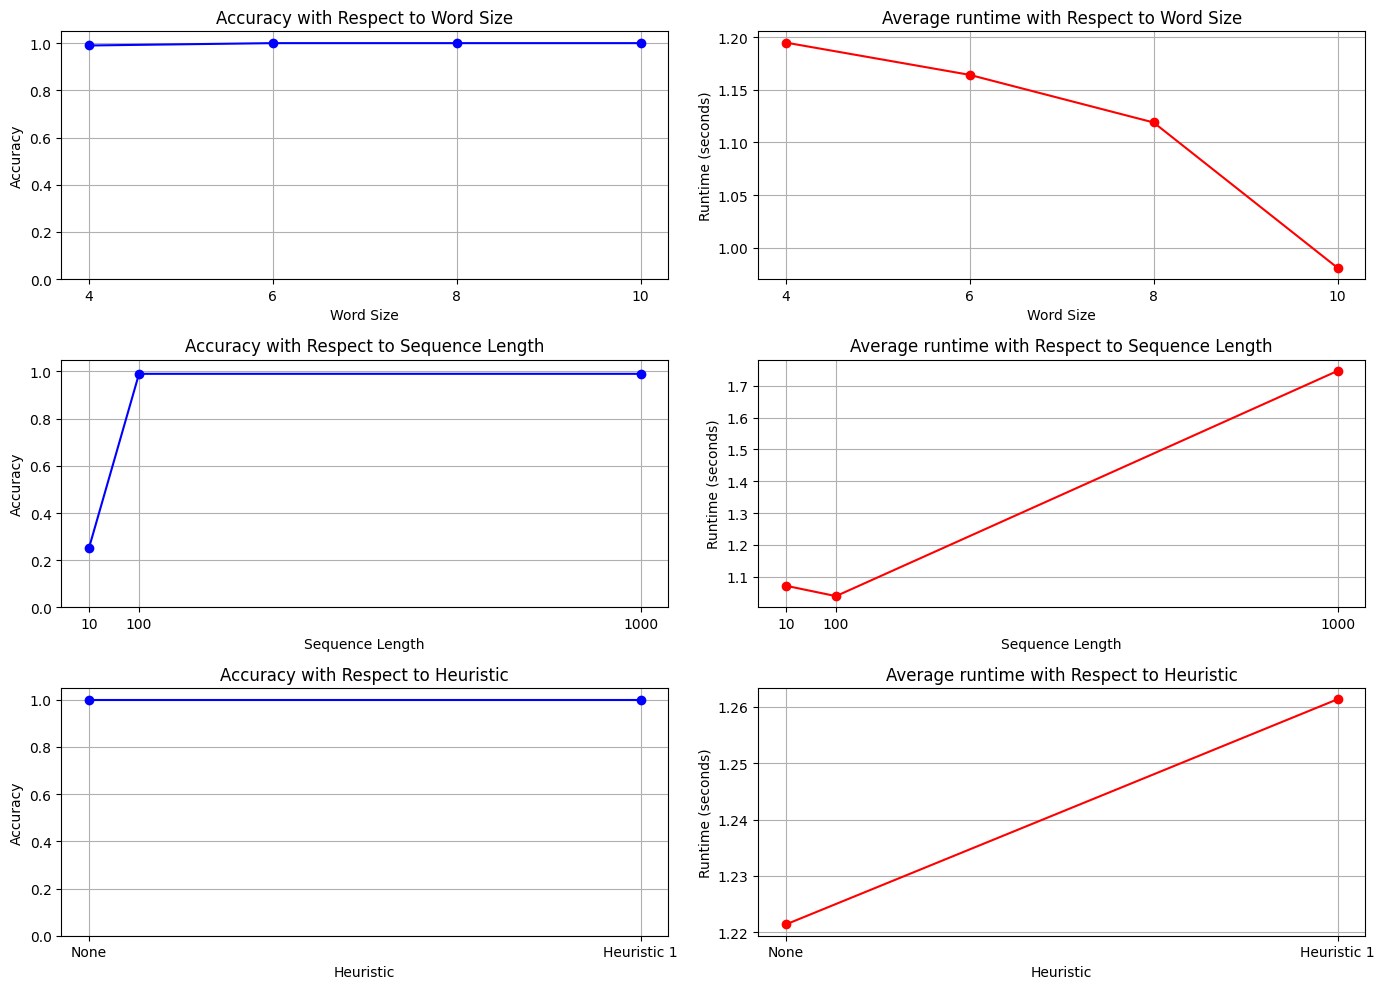

[0.99, 1.0, 1.0, 1.0]
[0.25, 0.99, 0.99]
[1.0, 1.0]


In [5]:
plt.figure(figsize=(14, 10))  # Adjust width (14) and height (5) as desired

# Plot accuracy
plt.subplot(3, 2, 1)
plt.plot(word_sizes, accuracies['word_size'], marker='o', linestyle='-', color='b')
plt.title("Accuracy with Respect to Word Size")
plt.xlabel("Word Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(word_sizes)
plt.ylim(0, 1.05)  # To make the accuracy range from 0 to slightly above 1

# Plot runtime
plt.subplot(3, 2, 2)
plt.plot(word_sizes, average_run_times['word_size'], marker='o', linestyle='-', color='r')
plt.title("Average runtime with Respect to Word Size")
plt.xlabel("Word Size")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.xticks(word_sizes)


# Plot accuracy
plt.subplot(3, 2, 3)
plt.plot(sequence_lengths, accuracies['sequence_length'], marker='o', linestyle='-', color='b')
plt.title("Accuracy with Respect to Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sequence_lengths)
plt.ylim(0, 1.05)  # To make the accuracy range from 0 to slightly above 1

# Plot runtime
plt.subplot(3, 2, 4)
plt.plot(sequence_lengths, average_run_times['sequence_length'], marker='o', linestyle='-', color='r')
plt.title("Average runtime with Respect to Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.xticks(sequence_lengths)


# Plot accuracy
plt.subplot(3, 2, 5)
plt.plot(heuristics, accuracies['heuristic'], marker='o', linestyle='-', color='b')
plt.title("Accuracy with Respect to Heuristic")
plt.xlabel("Heuristic")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(heuristics, labels=["None", "Heuristic 1"])
plt.ylim(0, 1.05)  # To make the accuracy range from 0 to slightly above 1

# Plot runtime
plt.subplot(3, 2, 6)
plt.plot(heuristics, average_run_times['heuristic'], marker='o', linestyle='-', color='r')
plt.title("Average runtime with Respect to Heuristic")
plt.xlabel("Heuristic")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.xticks(heuristics, labels=["None", "Heuristic 1"])


plt.tight_layout()
plt.show()

print(accuracies['word_size'])
print(accuracies['sequence_length'])
print(accuracies['heuristic'])